# Lab 5: Neural Networks for Text Classification

This lab introduces (deep) neural networks for text classification using Pytorch, and applies it to the datasets we previously used with naïve Bayes and logistic regression.

You may also find [Pytorch's tutorials](https://pytorch.org/tutorials/) useful.

### Outcomes
* Be able to construct and train a neural network classifier in Pytorch.
* Understand how to use word embeddings as input to a neural network.
* Know how to compare classifier performance on a test set.


# 1. Loading the Data

This section contains the same loader code as last week.

In [1]:
from datasets import load_dataset
from tqdm import tqdm

cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Training dataset with {len(train_dataset)} instances loaded")

dev_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Development/validation dataset with {len(dev_dataset)} instances loaded")

test_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Test dataset with {len(test_dataset)} instances loaded")

# Put the data into lists ready for the next steps...
train_texts = []
train_labels = []
for i in tqdm(range(len(train_dataset))):
    train_texts.append(train_dataset[i]['text'])
    train_labels.append(train_dataset[i]['label'])

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 45615 instances loaded


Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Development/validation dataset with 2000 instances loaded


Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 12284 instances loaded


100%|██████████| 45615/45615 [00:05<00:00, 8618.72it/s]


# 2. Preparing the Data
Now we put the dataset into a suitable format for a Pytorch NN classifier.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2

As inputs to the Sklearn classifiers in week 3, we used CountVectorizer to extract a single vector representation for a *whole document*.
However, one motivation for using a neural network is that it can learn to combine the tokens automatically, so we don't need to pass in a document vector.
Instead, as input to our neural network, we will pass in each token as its *input_id*, which is its index into a vocabulary.

The first step is to compute the vocabulary:

In [3]:
# Use CountVectorizer to obtain a vocabulary
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import tokenize

vectorizer = CountVectorizer(tokenizer=tokenize)  # use the Gensim tokenizer so we get consistency with the Gensim embeddings
vectorizer.fit(train_texts)

vocab = vectorizer.vocabulary_

/home/mc15455/anaconda3/envs/general38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
print(np.max(list(vocab.values())))
print(len(vocab))
print(type(vocab))

41235
41236
<class 'dict'>


Now, we have to map the tokens to their IDs -- their indexes in the vocabulary.

In [6]:
# tokenize training set and convert to input IDs.
def encode_text(sample):
    tokens = tokenize(sample['text'])
    input_ids = []
    for token in tokens:
        if str.lower(token) in vocab:  # Skip words from the dev/test set that are not in the vocabulary.
            input_ids.append(vocab[str.lower(token)]+1)
    sample['input_ids'] = np.array(input_ids)  # +1 is needed because we reserve 0 as a special character
    return sample

train_dataset = train_dataset.map(encode_text)
# for i in tqdm(range(len(train_dataset))):
#     train_dataset[i]['input_ids'] = encode_text(train_dataset[i])
# print(train_dataset[0])
# sample = encode_text(train_dataset[0])

  0%|          | 0/45615 [00:00<?, ?ex/s]

In [7]:
print(train_dataset[0])
# print(encode_text(train_dataset[0]))

{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2, 'input_ids': [28858, 38435, 17515, 36182, 26061, 10434, 25593, 36182, 36125, 4205, 29980, 21587, 35199, 36182, 2947, 25593, 16479, 15672]}


Our neural network's input layer has a fixed size, so we need to somehow make all of our documents have the same number of tokens. We can do this by setting a fixed sequence length, then *padding* the short documents with a special token. Any documents that exceed the length will be truncated. Let's plot a histogram to understand the length distribution of the texts.

Mean of the document length: 19.684752822536446
Median of the document length: 20.0
Maximum document length: 46


(array([5.0000e+01, 1.3000e+03, 6.5510e+03, 1.0287e+04, 1.6098e+04,
        8.6200e+03, 2.5290e+03, 1.6100e+02, 1.8000e+01, 1.0000e+00]),
 array([ 1. ,  5.5, 10. , 14.5, 19. , 23.5, 28. , 32.5, 37. , 41.5, 46. ]),
 <BarContainer object of 10 artists>)

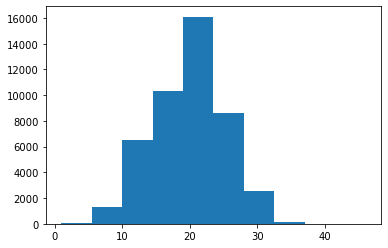

In [8]:
rv_l = [len(doc) for doc in train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

**TODO 2.1** Modify the padding code below to insert 0s at the start of any sequences that are too short, and to truncate any sequences that are too long.

In [18]:
sequence_length = 40  # truncate all docs longer than this. Pad all docs shorter than this.

def pad_text(sample):
    sequence_length = 40
    # pad 
    sample['input_ids'] = np.pad(sample['input_ids'], (0, sequence_length))
    sample['input_ids'] = sample['input_ids'][:sequence_length]
    return sample

train_dataset = train_dataset.map(pad_text)

  0%|          | 0/45615 [00:00<?, ?ex/s]

In [20]:
# check it worked
result = 'all good'
for example in tqdm(train_dataset):
    if len(example['input_ids']) != sequence_length:
        result = 'fail'
        break
print(result)

100%|██████████| 45615/45615 [00:04<00:00, 10942.63it/s]

all good


We now have our data in the right format. When training, the neural network will process the data in randomly-chosen mini-batches.
To enable this, we wrap our dataset in a DataLoader

DataLoader: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [21]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# convert from the Huggingface format to a TensorDataset so we can use the mini-batch sampling functionality
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

num_classes = len(np.unique(train_labels))   # number of possible labels in the sentiment analysis task

train_loader = convert_to_data_loader(train_dataset, num_classes)

Let's process the development and test set as well.

In [22]:

dev_dataset = dev_dataset.map(encode_text)
dev_dataset = dev_dataset.map(pad_text)
dev_loader = convert_to_data_loader(dev_dataset, num_classes)

test_dataset = test_dataset.map(encode_text)
test_dataset = test_dataset.map(pad_text)
test_loader = convert_to_data_loader(test_dataset, num_classes)

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/12284 [00:00<?, ?ex/s]

  0%|          | 0/12284 [00:00<?, ?ex/s]

# 3. Constructing the Network

We will build a NN with three different layers for sentiment classification.

### Embedding layer
In the embedding layer, the network will create its own embeddings for the index with a given embedding dimension.
The module `nn.Embedding()` creates a simple lookup table that stores embeddings of a fixed dictionary and size.
This module is often used to store word embeddings and retrieve them using indices.
The module's input is a list of indices, and the output is the corresponding word embeddings.

[Documentation for Embedding Class](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

### Fully-connected layer
Fully-connected layers in a neural network are those layers where all the inputs from the previous layer are connected to every unit of the fully-connected layer.
Here we will use fully-connected layers for the hidden layer and output layer. In Pytorch this kind of layer is implemented by the 'Linear' class:

[Documentation for Linear Class](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

## Activation functions
In Pytorch, the activation function is not included in the Linear class (or other kinds of neural network layer).
In Pytorch, we construct a neural network by connecting up the output of each component to the input of the next, thereby creating a computation graph.
To complete the hidden layer, we connect the ouput of a linear layer to a ReLU activation function, thereby creating a nonlinear function.

**TODO 3.1** Complete the constructor for a NN with three layers by adding the missing dimensions.

**TODO 3.2** Complete the forward function that maps the input data to an output by adding the missing line.

In [59]:
from torch import nn

class FFTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size

        ### COMPLETE THE CODE HERE: WRITE IN THE MISSING ARGUMENTS SPECIFYING THE DIMENSIONS OF EACH LAYER

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) # embedding layer
        self.hidden_layer = nn.Linear(sequence_length*embedding_size, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size, num_classes) # Full connection layer

        ##########
        
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size
        z = self.hidden_layer(embedded_words)   # (batch_size, seq_length, hidden_size)

        ### ADD THE MISSING LINES HERE
        h = self.activation(z)
        ########

        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 25  # number of dimensions for embeddings
hidden_size = 32 # number of hidden units

###WRITE YOUR OWN CODE HERE

model = FFTextClassifier(vocab_size, embedding_size, hidden_size, num_classes)

**TODO 3.3** Create a NN with the FFTextClassifier class we wrote.

**Hint:** `model = FFTextClassifier(...)`

In [39]:
vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 25  # number of dimensions for embeddings
hidden_size = 32 # number of hidden units

###WRITE YOUR OWN CODE HERE

model = FFTextClassifier(vocab_size, embedding_size, hidden_size, num_classes)

After desigining our network, we need to create a training function to calculate the loss for each input and perform backpropagation to optimise the network.
During training, the weights of all the layer will be updated.

We build a training function to train the NN over a fixed number of epochs (an epoch is one iteration over the whole training dataset).
The function also prints the performance of both training and development/validation set after each epoch.

**TODO 3.4** Complete the code below to compute the validation accuracy and loss after each training epoch.

In [61]:
def train_nn(num_epochs, model, train_dataloader, dev_dataloader, loss_fn, optimizer):
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))

        model.eval()  # Switch model to evaluation mode
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_labels in dev_dataloader:
            ###WRITE YOUR OWN CODE HERE
            dev_output = model(dev_input_ids)
            #######
            dev_loss = loss_fn(dev_output, dev_labels)
            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())

            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
    return model


The last step before we start training is defining the loss function and optimizer.

Here we use cross-entropy loss and the Adam optimizer (it tends to find a better solution in a small number of iterations than SGD).
The module `nn.CrossEntropyLoss()` combines `LogSoftmax` and `NLLLoss` in one single class so that we don't have to implement the softmax layer within the forward() method.

Cross Entropy Loss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Optimization: https://pytorch.org/docs/stable/optim.html

**TODO 3.4** Finally, train the network for 10 epochs!

In [64]:
from torch import optim

learning_rate = 0.0005

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

###WRITE YOUR OWN CODE HERE
trained_model = train_nn(10, 
         model, 
         train_loader, 
         dev_loader, 
         loss_fn, 
         optimizer)


Epoch: 1/10 Training Loss: 0.4886 Training Accuracy: 80.0811%
Epoch: 1/10 Validation Loss: 1.0780 Validation Accuracy: 57.6000%
Epoch: 2/10 Training Loss: 0.4536 Training Accuracy: 81.7933%
Epoch: 2/10 Validation Loss: 1.1092 Validation Accuracy: 58.0000%
Epoch: 3/10 Training Loss: 0.4190 Training Accuracy: 83.1985%
Epoch: 3/10 Validation Loss: 1.1539 Validation Accuracy: 57.7500%
Epoch: 4/10 Training Loss: 0.3872 Training Accuracy: 84.9457%
Epoch: 4/10 Validation Loss: 1.2052 Validation Accuracy: 58.8500%
Epoch: 5/10 Training Loss: 0.3587 Training Accuracy: 86.0660%
Epoch: 5/10 Validation Loss: 1.2763 Validation Accuracy: 57.0000%
Epoch: 6/10 Training Loss: 0.3303 Training Accuracy: 87.5041%
Epoch: 6/10 Validation Loss: 1.3009 Validation Accuracy: 58.0500%
Epoch: 7/10 Training Loss: 0.3053 Training Accuracy: 88.5301%
Epoch: 7/10 Validation Loss: 1.4041 Validation Accuracy: 57.9000%
Epoch: 8/10 Training Loss: 0.2800 Training Accuracy: 89.7446%
Epoch: 8/10 Validation Loss: 1.4441 Valida

**TODO 3.5:** Evaluate the model on test set using the function below. Complete the code to count the correct classifications.

In [75]:
def test_nn(trained_model, test_loader, loss_fn):

    trained_model.eval()

    test_losses = []
    correct = 0  # count the number of correct classification labels

    for inputs, labels in test_loader:
        test_output = trained_model(inputs)
        loss = loss_fn(test_output, labels)
        test_losses.append(loss.item())
        predicted_labels = test_output.argmax(1)

        ###WRITE YOUR OWN CODE HERE
        for i in range(len(labels)):
            if predicted_labels[i]==labels[i]:
                correct += 1
        ######

    accuracy = correct/len(test_loader.dataset)*100
    print("Test Accuracy: {:.2f}%".format(accuracy))
    # print(predicted)

test_nn(trained_model, test_loader, loss_fn)

Test Accuracy: 52.13%


# 4. Pretrained Embeddings

Now let's use pretrained word embeddings as inputs instead of learning them from scratch during training.
Here, we will use a pretrained embedding matrix to initialise the embedding layer, which will then be updated during training.

The class below extends the FFTextClassifier class. This means that it inherits all of its functionality, but we now overwrite the constructor (the `__init__` method).
This way, we don't need to define the forward function again, as it will be the same as before.

**TODO 4.1** As before, complete the arguments below to set the dimensions of the neural network layers.

In [ ]:
import gensim.downloader

class FFTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        # download pretrained embeddings as the intial values for out embedding layer.
        embedding_matrix = gensim.downloader.load('glove-twitter-25')  # 'word2vec-google-news-300')
        self.embedding_size = embedding_matrix.vectors.shape[1]
        embedding_matrix_reordered = torch.zeros((vocab_size, self.embedding_size))
        for word in vocab:
            if word in embedding_matrix:
                embedding_matrix_reordered[vocab[word]] = torch.from_numpy(embedding_matrix[word])

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix_reordered, freeze=False) # embedding layer

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(???) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(???) # Full connection layer

**TODO 4.2** Using the above class, construct, train and test the classifier with pretrained embeddings. You will need to create a new optimizer object.

In [ ]:
### WRITE YOUR OWN CODE BELOW
